# 1. Introdução

O dataset escolhido para o trabalho foi encontrado no Kaggle e contém notícias do site folha uol. E se chama ["News of the Brazilian Newspaper"](https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol), nesse conjunto de dados há 167.053 notícias com seus respectivos títulos e categorias.

A partir desse conjunto de dados testarei diversos modelos de classificação para o texto, mostrarei os resultados obtidos e descorrerei sobre os omelhores.

# 2. Desenvolvimento

## 2.1. Bibliotecas

Bibliotecas utilizadas no projeto.

In [173]:
!pip install unidecode

In [1]:
import re
import time
import nltk
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from unidecode import unidecode
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import ( make_scorer, accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, f1_score,
                             matthews_corrcoef)

# import warnings
# warnings.filterwarnings("ignore")

## 2.2. Funções customizadas

Frunções criadas para auxiliar no desenvolvimento do projeto.

In [3]:
class color:
    """A class that provides ANSI escape codes for text color formatting.

    Args:
        PURPLE (str): ANSI escape code for purple text.
        CYAN (str): ANSI escape code for cyan text.
        DARKCYAN (str): ANSI escape code for dark cyan text.
        BLUE (str): ANSI escape code for blue text.
        GREEN (str): ANSI escape code for green text.
        YELLOW (str): ANSI escape code for yellow text.
        RED (str): ANSI escape code for red text.
        BOLD (str): ANSI escape code for bold text.
        UNDERLINE (str): ANSI escape code for underlined text.
        END (str): ANSI escape code to reset text formatting.

    Usage:
        Use the attributes of this class to format text with different colors,
        styles, and effects. For example:

        print((color.BOLD) + 'Hello, world!' + color.END)
        print((color.RED) + 'Error: Something went wrong.' + color.END)

    """
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def remove_punctuation(text):
    """Remove punctuation and numbers from text

    Args:
        text (str): A string

    Returns:
        str: string without punctuation and numbers
    """
    return re.sub(r'[^a-zA-Z\s]', ' ', text)

def remove_multiple_blank_spaces(text):
    """Remove multiple blank spaces from text

    Args:
        text (str): A string

    Returns:
        str: string with only one space between words
    """
    return re.sub(r'\s+', ' ', text)

def hyper_tunning(model_name, model, param_grid, X_train, y_train, X_val, y_val):
    """
    Perform hyperparameter tuning using GridSearchCV.

    Args:
        model_name (str): Name of the model.
        model: The model object or estimator.
        param_grid (dict): Dictionary of hyperparameters to search over.
        X_train: Training data.
        y_train: Target variable for training data.

    Returns:
        None

    Prints:
        Information about the hyperparameter tuning process, including the best parameters,
        best score, validation MCC (Matthews Correlation Coefficient), and elapsed time.

    """
    t_start = time.time()
    scorer_mcc = make_scorer(matthews_corrcoef)

    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring=scorer_mcc, n_jobs=-1)

    # Perform the grid search by fitting training data
    grid_search.fit(X_train, y_train)

    best_estimator = grid_search.best_estimator_
    valid_mcc = best_estimator.score(X_val, y_val)

    t_end = time.time()
    print(f"{color.BOLD}- {model_name}{color.END}\nBest parameters: {grid_search.best_params_}\nBest score: {grid_search.best_score_:.4%}\nValid MCC: {valid_mcc:.4%}\nElapsed: {t_end-t_start:.4f} sec\n")

def style_score(val, quantile_val, invert=False):
    """
    Apply styling to a score based on its value and quantile range.

    Args:
        val (float): The score value.
        quantile_val (tuple): The quantile range as a tuple of two floats. (<25% and >75%)
        invert (bool, optional): Whether to invert the styling. Defaults to False.

    Returns:
        str: The styling string to be used in HTML or CSS.

    """
    if type(val) == str:
        return None
    if invert:
        return "color:red;" if val > quantile_val[0] else ( "color:blue;" if val <= quantile_val[1] else "color:gray;")
    return "color:red;" if val < quantile_val[0] else ( "color:blue;" if val >= quantile_val[1] else "color:gray;")

## 2.3. Carregando o dado

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
%%time
# Load data
data = pd.read_csv("Input/archive.zip", low_memory=False)
# data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/2023/Studies_proj_text_classification/Input/archive.zip", low_memory=False)
data.head(3)

CPU times: total: 3.05 s
Wall time: 9.36 s


,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...


## 2.4. Primeira análise

Foco em exploração do conjunto de dados

In [5]:
%%time
# Show if there is empty values by columns
data.isnull().sum()

CPU times: total: 31.2 ms
Wall time: 158 ms


title               0
text              765
date                0
category            0
subcategory    137418
link                0
dtype: int64

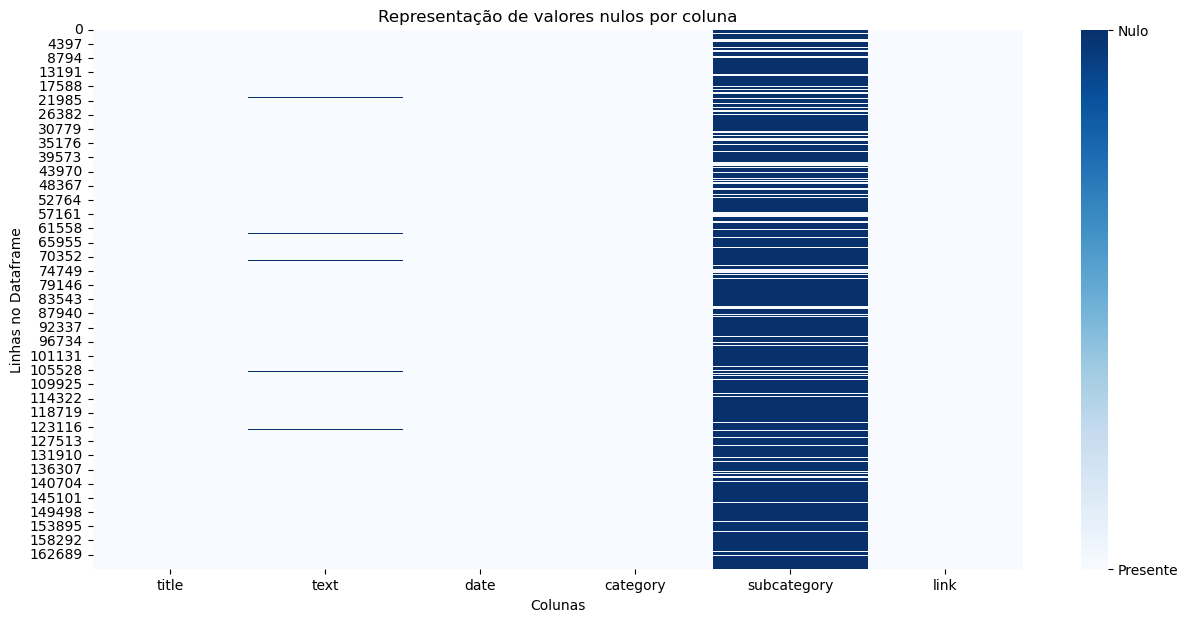

CPU times: total: 375 ms
Wall time: 1.45 s


In [7]:
%%time
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(data.isnull(), cmap="Blues", ax=ax)

# Define os rótulos personalizados para os valores da legenda
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Presente', 'Nulo'])

ax.set(title="Representação de valores nulos por coluna", ylabel="Linhas no Dataframe", xlabel="Colunas")
plt.show()

In [8]:
# Remove rows with missing text
mask = data.text.isnull()
data = data[~mask]

In [9]:
%%time
# Count items by category
data.groupby("category").count().sort_values(by="title", ascending=False)

CPU times: total: 156 ms
Wall time: 158 ms


,title,text,date,subcategory,link
category,,,,,
poder,22022,22022,22022,939,22022
colunas,21619,21619,21619,21619,21619
mercado,20970,20970,20970,0,20970
esporte,19730,19730,19730,2859,19730
mundo,17130,17130,17130,0,17130
cotidiano,16967,16967,16967,35,16967
ilustrada,15617,15617,15617,0,15617
opiniao,4525,4525,4525,0,4525
paineldoleitor,4011,4011,4011,260,4011


## 2.5. Preparação do dados

Seleciona as categorias com mais de 1500 notícias no mínimo e agrupa das demais na categorias "outros".

In [13]:
%%time
# To avoid small categories, we will remove the categories with less than 1500 items
categories_mask = data["category"].value_counts() > 1500
categories_mask = categories_mask[categories_mask.values].index

data_reorganized = data.copy()
# All categories discarded above will be grouped in a new category called "outros"
mask = data.category.isin(categories_mask)
data_reorganized.loc[~mask, "category"] = "outros"

# Result dataset
data_reorganized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166288 entries, 0 to 167052
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        166288 non-null  object
 1   text         166288 non-null  object
 2   date         166288 non-null  object
 3   category     166288 non-null  object
 4   subcategory  29611 non-null   object
 5   link         166288 non-null  object
dtypes: object(6)
memory usage: 8.9+ MB
CPU times: total: 78.1 ms
Wall time: 172 ms


### 2.5.1. Separa os dados

A seguir os dados serão separados em treino, teste e validação.

In [14]:
%%time
seed = 333
#data_reorganized = data_reorganized.copy().groupby('category').apply(lambda x: x.sample(1500, random_state=seed))

# Store the unused data for future use
# balanced_index = set(data_balanced.unstack(level=0).index)
# balanced_categories = data_balanced.category.unique()
# mask = ~(data_reorganized.index.isin(balanced_index)) & (data_reorganized.category.isin(balanced_categories))
# data_unbalanced = data_reorganized[mask].reset_index(drop=True)

# Balanced data
data_reorganized.reset_index(drop=True, inplace=True)
data_reorganized.category.value_counts()

CPU times: total: 0 ns
Wall time: 7.32 ms


poder             22022
colunas           21619
mercado           20970
esporte           19730
mundo             17130
cotidiano         16967
ilustrada         15617
outros            11338
opiniao            4525
paineldoleitor     4011
saopaulo           3955
tec                2260
tv                 2123
educacao           2118
turismo            1903
Name: category, dtype: int64

### 2.5.2. Preparação do texto

Será criada duas novas colunas no dataframe. A primeira coluna consiste do título e texto da notícia combinados em uma única string e a segunda coluna é umas cópia dessa coluna recém criada mas com os números, acentos e pontuações removidos.

In [15]:
%%time
# Combining text and title
df_selected = data_reorganized[["title", "text", "category"]].copy()
df_selected["full_text"] = df_selected["title"] + " " + df_selected["text"]
# Text cleaning
df_selected["norm_text"] = df_selected.full_text.apply(lambda x: remove_multiple_blank_spaces(
                                                remove_punctuation(
                                                    unidecode(str(x).lower())
                                                )
                                            ).strip())
df_selected = df_selected[["full_text", "norm_text", "category"]]
df_selected.head()

# i5 7600 - 2 min 16 sec

CPU times: total: 49.4 s
Wall time: 2min 16s


,full_text,norm_text,category
0,"Lula diz que está 'lascado', mas que ainda tem...",lula diz que esta lascado mas que ainda tem fo...,poder
1,"'Decidi ser escrava das mulheres que sofrem', ...",decidi ser escrava das mulheres que sofrem diz...,ilustrada
2,Três reportagens da Folha ganham Prêmio Petrob...,tres reportagens da folha ganham premio petrob...,poder
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,filme star wars os ultimos jedi ganha trailer ...,ilustrada
4,CBSS inicia acordos com fintechs e quer 30% do...,cbss inicia acordos com fintechs e quer do cre...,mercado


In [16]:
%%time
# Change category to numeric
df_selected["category"] = df_selected.category.astype("category")
category_map = {key: value for key, value in zip(df_selected.category, df_selected.category.cat.codes)}
df_selected.category = df_selected.category.cat.codes

CPU times: total: 31.2 ms
Wall time: 57.5 ms


### 2.5.3. Split data

O conjunto de dados é separado em treino, teste e valida.

 1. **Treino** é composto por **80%** do conjunto de dados randomicamente selecionado.
 2. Em seguida, os **20%** restante são divididos igualmente (**50%/50%**) entre **Teste** e **Valida**

In [17]:
%%time
# Split Data

df_train, df_test = train_test_split(df_selected, test_size=0.2, random_state=seed, stratify=df_selected.category)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=seed, stratify=df_test.category)

df_train.shape, df_test.shape, df_val.shape

CPU times: total: 62.5 ms
Wall time: 168 ms


((133030, 3), (16629, 3), (16629, 3))

## 2.6. Stop words and vectorization

Carrega a stopwords e faz a vetorização dos dados utilizando o TF-IDF.

 1. Combinei as stopwords da biblioteca spacy e ntlk.
 2. Removi a acentuação das stopwords após uma leve melhora nos resultado


In [187]:
# Uncomment and use to download the stopwords data
#! python3 -m spacy download pt_core_news_sm
#nltk.download('stopwords')

In [18]:
%%time
# Stopwords
stopwords_nltk = stopwords.words('portuguese')
stopwords_spacy = spacy.load('pt_core_news_sm').Defaults.stop_words
both_stopwords = set(stopwords_nltk) | set(stopwords_spacy)
both_stopwords = list(map(unidecode, both_stopwords))

# Create a TfidfVectorizer object
vector = TfidfVectorizer(stop_words=both_stopwords, max_features=2000,
                             ngram_range=(1, 2), min_df=5, max_df=0.8, lowercase=True)

vector.fit(df_train.norm_text)

# i5 7600 - 2 min 54 sec

CPU times: total: 1min 8s
Wall time: 2min 54s


TfidfVectorizer(max_df=0.8, max_features=2000, min_df=5, ngram_range=(1, 2),
                stop_words=['minhas', 'novo', 'contudo', 'dela', 'saber',
                            'somente', 'grupo', 'estivemos', 'terceira',
                            'estivessem', 'terei', 'estivestes', 'nada',
                            'todas', 'quero', 'favor', 'podera', 'estavam',
                            'certeza', 'quinze', 'era', 'quais', 'fara',
                            'hajam', 'coisa', 'ontem', 'ca', 'teriam', 'cujo',
                            'contra', ...])

In [19]:
%%time
# Text to vectors
X_train = vector.transform(df_train.norm_text)
X_val = vector.transform(df_val.norm_text)
X_test = vector.transform(df_test.norm_text)

y_train = df_train.category
y_val = df_val.category
y_test = df_test.category
# i5 7600 - 1 min 41 sec

CPU times: total: 32.7 s
Wall time: 1min 41s


In [20]:
%%time
X_train.shape, X_val.shape, X_test.shape

CPU times: total: 0 ns
Wall time: 0 ns


((133030, 2000), (16629, 2000), (16629, 2000))

## 2.7. Analise de N-grams

Foco em observar quais palavras mais se relacionam (aparecem próximas)

In [21]:
%%time
X_train_sum = np.sum(X_train, axis=0)
sorted_ngrams = np.asarray(np.argsort(X_train_sum)[::-1]).reshape(-1)

# Get the top 30 ngrams
top_ngrams = sorted_ngrams[:30]
feature_names = np.array(vector.get_feature_names_out())

# reshape a list into a list of strings with 3 "rows", each ngram is separated by '-'
[ " - ".join(ii) for ii in np.array_split(feature_names[top_ngrams], 3) ]

CPU times: total: 31.2 ms
Wall time: 52 ms


['noites - seg - aereo - joesley - favoravel - simplesmente - analisar - ex diretor - renan calheiros - empreiteira',
 'nesses - investigado - contexto - iria - casa civil - aceitar - longo prazo - artigos - coordenador - provavel',
 'lavagem - proteger - vir - estimular - and - fiz - aumentou - industrial - constitucional - perguntas']

## 2.8. Teste preliminar de modelos

Diferentes modelos para foram avaliados em busca dos melhores candidatos.

Testes executados:
 1. Com subsampling de 300 textos
    - Com e sem a remoção da acentuação das stopwords
 2. Com subsampling de 1500
    - Com e sem a remoção da acentuação das stopwords
 3. Com o conjunto total dos textos
    - Com a remoção da acentuação das stopwords

A quantidade de elementos e a qualidade dos resultados se correlacionaram positivamente e o melhor resultado foi obtido com a totalidade dos dados como podemos ver a seguir:

**Atenção:** Para esse passo foi utilizado o algoritmo **train_models** desenvolvido pelo Prof. Dr. Elias Jacob de Menezes Neto e disponibilizado na [Aula 03](https://colab.research.google.com/drive/1_9ReXGzrH0jbKHiyaBNmYsUpV-myjLvu#scrollTo=zx0xFPnSjuis).

In [22]:
%%time
df_results = pd.read_csv("df_results.csv", low_memory=False)
# df_results = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/2023/Studies_proj_text_classification/df_results.csv", low_memory=False)

df_results["Time/F1"] = df_results.F1/df_results["Total Time"]
df_stl = df_results.sort_values(by="Time/F1", ascending=False).drop(["Confusion Matrix", "Classification Report"], axis=1)

quantiles_dict = {}
for col in df_stl.columns[1:]:
    quantiles_dict[col] = df_stl[col].quantile([.25, .75]).values

df_stl.style.format({"F1": "{:.4%}", "BACC": "{:.4%}", "ACC": "{:.4%}",
                     "MCC": "{:.4%}", "Total Time": "{:.4f} sec", "Time/F1": "{:.4f}"}) \
                        .applymap(style_score, quantile_val=quantiles_dict["F1"], subset=["F1"]) \
                        .applymap(style_score, quantile_val=quantiles_dict["BACC"], subset=["BACC"]) \
                        .applymap(style_score, quantile_val=quantiles_dict["ACC"], subset=["ACC"]) \
                        .applymap(style_score, quantile_val=quantiles_dict["MCC"], subset=["MCC"]) \
                        .applymap(style_score, quantile_val=quantiles_dict["Time/F1"], subset=["Time/F1"]) \
                        .applymap(style_score, quantile_val=quantiles_dict["Total Time"], invert=True, subset=["Total Time"])

CPU times: total: 46.9 ms
Wall time: 61.5 ms


,Model,F1,BACC,ACC,MCC,Total Time,Time/F1
7,NB,71.0463%,63.4310%,71.0463%,67.9315%,0.1759 sec,4.0400
6,SGD,76.4995%,78.3122%,76.4995%,74.2078%,1.3265 sec,0.5767
8,LSVC,80.2047%,79.0574%,80.2047%,78.0638%,17.8661 sec,0.0449
1,LR,79.2290%,80.3418%,79.2290%,77.0578%,26.6815 sec,0.0297
0,Calibrated-LSVC,81.0487%,75.4381%,81.0487%,78.8893%,72.7646 sec,0.0111
2,RF,78.5227%,73.2437%,78.5227%,76.1251%,305.5440 sec,0.0026
3,LGBM,82.7667%,82.3218%,82.7667%,80.8845%,434.1281 sec,0.0019
10,DT,60.8225%,59.3298%,60.8225%,56.4052%,373.4289 sec,0.0016
5,MLP,81.6713%,76.9997%,81.6713%,79.5946%,630.8444 sec,0.0013
4,XGB,82.1262%,76.8695%,82.1262%,80.0853%,1328.1116 sec,0.0006


## 2.9. Ensemble Classifier Explanation

A partir dos resultados anteriores escolhemos os três modelos com melhor relação F1/Tempo Total.

 - NB
 - SGD
 - LSVC

In [193]:
%%time
model_nb = MultinomialNB()
model_sgd = SGDClassifier(random_state=seed, n_jobs=-1, class_weight='balanced')
model_lsvc = LinearSVC(random_state=seed, class_weight='balanced')

estimators = [('NB', model_nb),
              ('SGD', model_sgd),
              ('LSVC', model_lsvc)]

model_stacked = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=seed, n_jobs=-1, class_weight='balanced'), n_jobs=-1, cv=5)

model_stacked.fit(X_train, y_train)
pred = model_stacked.predict(X_val)

f1 = f1_score(y_val, pred, average='micro')
bacc = balanced_accuracy_score(y_val, pred)
acc = accuracy_score(y_val, pred)
# cr = classification_report(y_val, pred)
mcc = matthews_corrcoef(y_val, pred)
cm = confusion_matrix(y_val, pred)

print(f'F1: {f1:.4f} - BACC: {bacc:.4f} - ACC: {acc:.4f} - MCC: {mcc:.4f}')

# 11 min xeon

F1: 0.8076 - BACC: 0.8076 - ACC: 0.8076 - MCC: 0.7939


Como podemos observar, utilizando os modelos NB, SGD e LSVC como estimadores melhoramos o F1 em X%

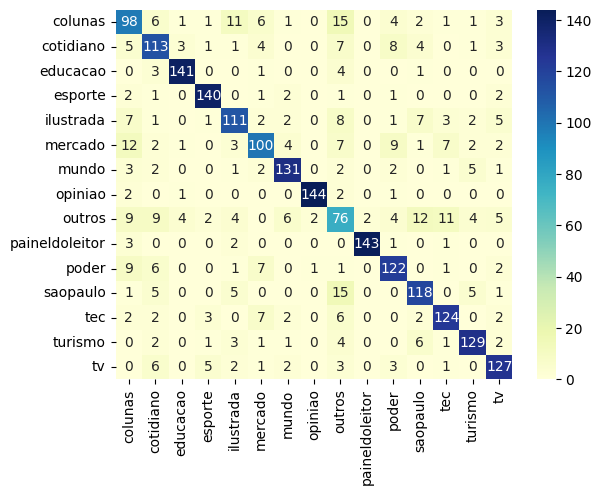

In [194]:
%%time
cm = confusion_matrix(y_val, pred)
# print(cm)

cm_matrix = pd.DataFrame(data=cm, columns=category_map.keys(), index=category_map.keys())
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
# mnb = MultinomialNB()
# probs = mnb.predict_proba(X_test)
# preds = probs[:,1]
# fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
# roc_auc = metrics.auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

## 2.10. Hyperparameter Optimization

Outra forma de melhorar os resultados obtidos é através da otimização dos hiperparâmetros.


### 2.10.1 - NB | Naive Bayes Multinomial

In [222]:
%%time
model_nb = MultinomialNB()
param_grid = {
    'alpha': [0, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'fit_prior': [True, False]
}
hyper_tunning("Naive Bayes Multinomial (NB)", model_nb, param_grid, X_train, y_train)

- Naive Bayes Multinomial
Best parameters: {'alpha': 0.0001, 'fit_prior': True}
Best score: 69.3468%
Valid MCC: 72.3111%
Elapsed: 2.7346 sec



### 2.10.2 - SGD | Linear models with stochastic gradient descent (SGD)

In [225]:
%%time
model_sgd = SGDClassifier(random_state=seed, n_jobs=-1, class_weight='balanced')
param_grid = {
    "loss": ['hinge', 'log_loss' 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    "max_iter": [1000, 2000, 3000, 4000, 5000],
    "penalty": ['l2', 'l1', 'elasticnet'],
    }
hyper_tunning("Linear models with stochastic gradient descent (SGD)".capitalize(), model_sgd, param_grid, X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 892, in fit
    self._more_validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 151, in _more_validate_params
    raise ValueError(
ValueError: alpha m

- Linear models with stochastic gradient descent (sgd)
Best parameters: {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}
Best score: 76.9492%
Valid MCC: 79.2889%
Elapsed: 10.3958 sec



### 2.10.3 - SVC | Linear Support Vector Classification

In [226]:
%%time
model_lsvc = LinearSVC(random_state=seed, class_weight='balanced')
param_grid = {
    "loss": ['hinge', 'squared_hinge'],
    "max_iter": [1000, 2000, 3000, 4000, 5000],
    "penalty": ['l2', 'l1'],
}
hyper_tunning("Linear Support Vector Classification (SVC)".capitalize(), model_lsvc, param_grid, X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty,

- Linear models with stochastic gradient descent (sgd)
Best parameters: {'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}
Best score: 76.8873%
Valid MCC: 79.7778%
Elapsed: 28.0719 sec



### 2.10.4 - LR | Logistic Regression

In [ ]:
%%time
model_lr = LogisticRegression(random_state=seed, n_jobs=-1, class_weight='balanced')
param_grid = {
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    "max_iter": [1000, 2000, 3000, 4000, 5000],
    "penalty": ['l2', 'l1', 'elasticnet'],
}
hyper_tunning("Logistic Regression (LR)".capitalize(), model_lr, param_grid, X_train, y_train)
